In [1]:
%matplotlib inline
from pathlib import Path

import numpy as np
import scipy.signal as sps

from spectrometer import FID1D, plot, process

Did not find any configuration file. Using defaults.


In [2]:
# Load raw *.fid data
file = Path("../data/20230719-160040-Water_1H_andrew_probe_9us_pulse_25us_delay.fid")
fid = FID1D.from_file(file)

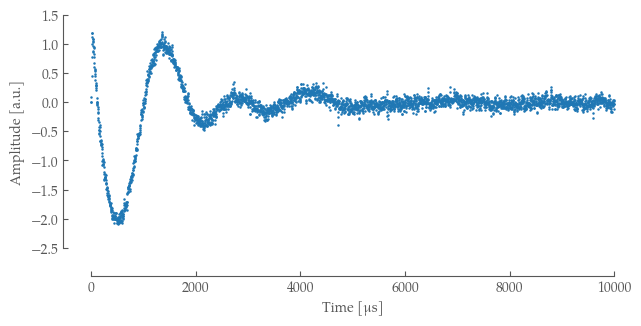

In [3]:
# Plot raw data
cm = 1 / 2.54
fig, axes = plot.subplots(
    figsize=(16.0 * cm, 8.0 * cm),  # Wide Layout: ~16cm, Margin Layout: 10.7cm
)
axes.plot(
    fid.us_scale,
    fid.data.real,
    linestyle="",
    marker="o",
    markersize=0.8,
)
axes.set_ylabel("Amplitude [a.u.]")
axes.set_xlabel("Time [μs]")

plot.format_axes(axes)

fig.savefig("fid_raw.pdf")

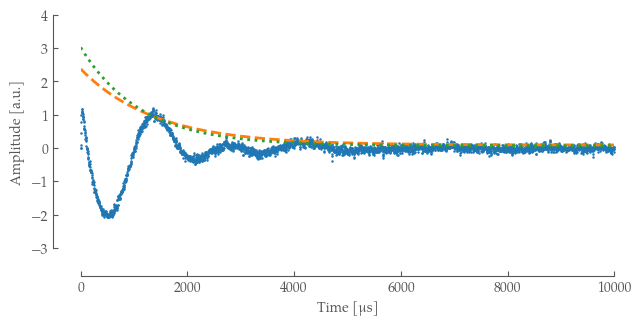

In [4]:
# Try to plot simple least squares fit
# Try fitting the envelope
envelope = np.abs(sps.hilbert(fid.data.real))
fit_lorentz = process.fit_exp_decay(fid.us_scale, envelope)
hz_scale_fine = np.linspace(fid.us_scale[0], fid.us_scale[-1], len(fid.us_scale) * 10)
axes.plot(
    hz_scale_fine,
    fit_lorentz["function"](hz_scale_fine),
    linestyle="--",
    linewidth=2,
)

# Try fitting the absolute directly
fit_abs = process.fit_exp_decay(fid.us_scale, np.abs(fid.data))
axes.plot(
    hz_scale_fine,
    fit_abs["function"](hz_scale_fine),
    linestyle=":",
    linewidth=2,
)

fig.savefig("fid_fit.pdf")
fig

Phase Shift: 63.394812500000086


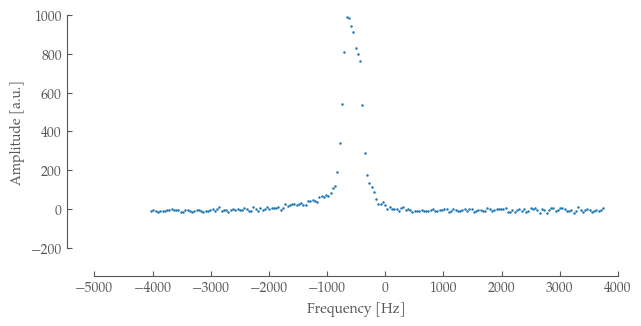

In [5]:
# Fourier Transform
hz_scale, fft_vals, p0 = fid.simple_fft()
peak_hz_scale = hz_scale[4000:4200]
peak_fft_vals = fft_vals[4000:4200]
print(f"Phase Shift: {p0}")

# Plot Fourier Transform
cm = 1 / 2.54
fig, axes = plot.subplots(
    figsize=(16.0 * cm, 8.0 * cm),  # Wide Layout: ~16cm, Margin Layout: 10.7cm
)
axes.plot(
    peak_hz_scale,
    peak_fft_vals.real,
    linestyle="",
    marker="o",
    markersize=0.8,
)
axes.set_ylabel("Amplitude [a.u.]")
axes.set_xlabel("Frequency [Hz]")

plot.format_axes(axes)

fig.savefig("fft_raw.pdf")

Amplitude: 1073.1354808356355
Gamma: 148.92571061019217 Hz
Position: -582.5681100383727 Hz


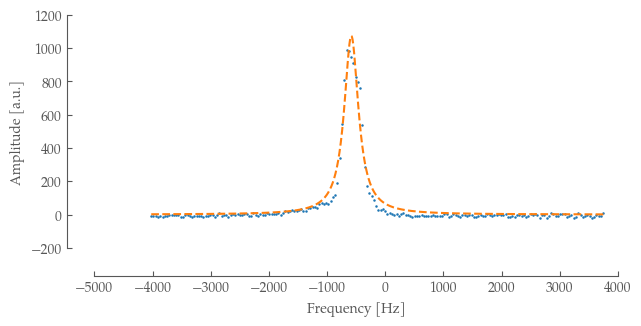

In [6]:
# Try to plot simple least squares fit for a lorentzian peak
fit_lorentz = process.fit_lorentz(peak_hz_scale, peak_fft_vals.real)
hz_scale_fine = np.linspace(peak_hz_scale[0], peak_hz_scale[-1], len(fid.us_scale) * 10)
axes.plot(
    hz_scale_fine,
    fit_lorentz["function"](hz_scale_fine),
    linestyle="--",
)
print(f"Amplitude: {fit_lorentz['amplitude']}")
print(f"Gamma: {fit_lorentz['gamma']} Hz")
print(f"Position: {fit_lorentz['position']} Hz")


fig.savefig("fft_fit.pdf")
fig